# SfM (Struture from Motion)

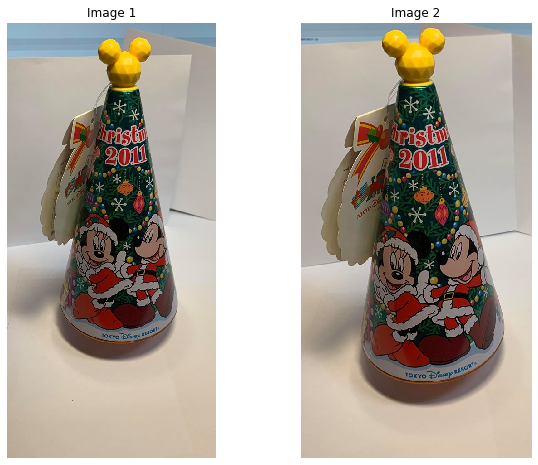

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from HW1 import calibrateCamera
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

# Mesona
# img1 = cv2.imread('./data/Mesona1.JPG')
# img2 = cv2.imread('./data/Mesona2.JPG')

# K1 = np.array([[1.4219, 0.0005, 0.5092],
#                [0, 1.4219, 0],
#                [0, 0, 0.0010]])*1000
# K2 = np.array([[1.4219, 0.0005, 0.5092],
#                [0, 1.4219, 0.3802],
#                [0, 0, 0.0010]])*1000

# Statue
# img1 = cv2.imread('./data/Statue1.bmp')
# img2 = cv2.imread('./data/Statue2.bmp')

# K1 = np.array([[5426.566895, 0.678017, 330.09668],
#                [0, 5423.133301, 648.950012],
#                [0, 0, 1]])
# K2 = np.array([[5426.566895, 0.678017, 387.430023],
#                [0, 5423.133301, 620.616699],
#                [0, 0, 1]])

# # Our data (Box)
# img1 = cv2.imread('./data/box1.jpg')
# img2 = cv2.imread('./data/box2.jpg')

# # Camera calibration
# intrinsic = calibrateCamera('data/chess_boards') # .JPG
# K1 = intrinsic
# K2 = intrinsic

# Our data (Disney)
img1 = cv2.imread('./data/disney1.jpg')
img2 = cv2.imread('./data/disney2.jpg')

K1 = np.array([[2701.93, 0.000, 1538.21],
               [0, 2738.09, 1960.13],
               [0, 0, 1]])
K2 = np.array([[2701.93, 0.000, 1538.21],
               [0, 2738.09, 1960.13],
               [0, 0, 1]])

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Image 1')
plt.imshow(img1[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Image 2')
_ = plt.axis('off')

## Feature Matching (SIFT)

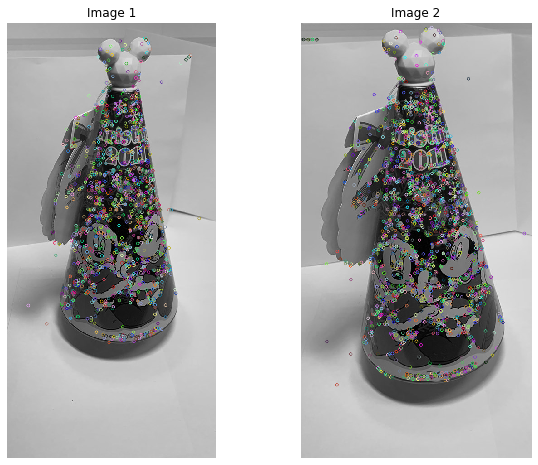

In [2]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

img1 = cv2.drawKeypoints(gray1, kp1, img1)
img2 = cv2.drawKeypoints(gray2, kp2, img2)

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Image 1')
plt.imshow(img1)

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Image 2')
_ = plt.axis('off')

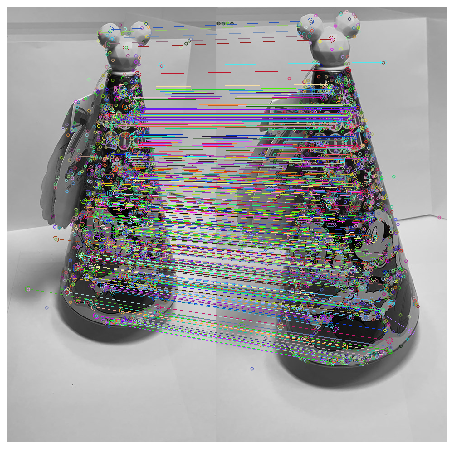

In [3]:
class DMatch():
    distance: float
    trainIdx: int
    queryIdx: int
    imgIdx: int

    def __init__(self):
        self.distance = 0.0
        self.trainIdx = 0
        self.queryIdx = 0
        self.imgIdx = 0
        
def knnMatch(des1, des2, k):
    n1, m1 = des1.shape
    n2, m2 = des2.shape

    dmatch_ary_final = []
    for i in range(n1):
        # calculate distance from des1 i to each des2
        dist_array = []
        dist_idx_array = []
        for j in range(n2):
            dist = np.sqrt(np.sum(np.square(des1[i] - des2[j])))
            dist_array.append(dist)
            dist_idx_array.append(j)

        # sort dist_array
        combined = zip(dist_array, dist_idx_array)
        zipped_sorted = sorted(combined, key=lambda x: x[0])
        dist_array, dist_idx_array = map(list, zip(*zipped_sorted))

        # select k smallest dist to be the result
        dmatch_ary = []
        for kn in range(k):
            dmatch = DMatch()
            dmatch.queryIdx = i
            dmatch.trainIdx = int(dist_idx_array[kn])
            dmatch.imgIdx = 0
            dmatch.distance = dist_array[kn]
            dmatch_ary.append(dmatch)

        dmatch_ary_final.append(dmatch_ary.copy())

    return dmatch_ary_final

def randomcolor():
    r = np.random.randint(0, 255)
    g = np.random.randint(0, 255)
    b = np.random.randint(0, 255)

    return [b, g, r]

def drawMatchesKnn(img1, kp1, img2, kp2, good):

    # Combine two images
    result = np.concatenate((img1, img2), axis=1)

    # Collect descriptors' coordinate
    src_temp = []
    dst_temp = []
    for i in good:
        src_temp.append(kp1[i[0].queryIdx].pt)
        dst_temp.append(kp2[i[0].trainIdx].pt)
    src_pts = np.asarray(src_temp) # (n,2)
    dst_pts = np.asarray(dst_temp) # (n,2)

    n, _ = src_pts.shape
    h1, w1, c1 = img1.shape
    
    for i in range(n):
        color = randomcolor()
        x1 = int(src_pts[i,0])
        y1 = int(src_pts[i,1])
        cv2.circle(result, (x1, y1), 7, color, 1)

        x2 = w1 + int(dst_pts[i,0])
        y2 = int(dst_pts[i,1])
        cv2.circle(result, (x2, y2), 7, color, 1)

        # (y-y1) / (y2-y1) - (x-x1) / (x2-x1)
        for x in range(x1, x2):
            y = y1 + ((x-x1)/(x2-x1)*(y2-y1))
            result[int(y), x] = color
        #cv2.line(result, (x1,y1), (x2, y2), color, 1)

    return result



# BFMatcher
matches = knnMatch(des1, des2, k=2)

# Apply ratio test
match_thres = 0.5
good = []
for m, n in matches:
    if m.distance < match_thres * n.distance: # 1st is more better than 2nd
        good.append([m])

# Store descriptors' coordinate
src_temp = []
dst_temp = []
for m in good:
    src_temp.append(kp1[m[0].queryIdx].pt)
    dst_temp.append(kp2[m[0].trainIdx].pt)
src_pts = np.asarray(src_temp) # (n,2)
dst_pts = np.asarray(dst_temp) # (n,2)



img3 = drawMatchesKnn(img1, kp1, img2, kp2, good)
plt.axis('off')
plt.imshow(img3[:,:,::-1])

## Fundamental Matrix
$X^{\top} F X^{\prime}=0$

$x^{\prime} x f_{11}+x^{\prime} y f_{12}+x^{\prime} f_{13}+y^{\prime} x f_{21}+y^{\prime} y f_{22}+y^{\prime} f_{23}+x f_{31}+y f_{32}+f_{33}=0$

$\mathbf{A f}=\left[\begin{array}{ccccccccc}
x_{1}^{\prime} x_{1} & x_{1}^{\prime} y_{1} & x_{1}^{\prime} & y_{1}^{\prime} x_{1} & y_{1}^{\prime} y_{1} & y_{1}^{\prime} & x_{1} & y_{1} & 1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_{n}^{\prime} x_{n} & x_{n}^{\prime} y_{n} & x_{n}^{\prime} & y_{n}^{\prime} x_{n} & y_{n}^{\prime} y_{n} & y_{n}^{\prime} & x_{n} & y_{n} & 1
\end{array}\right]\left[\begin{array}{c}
f_{11} \\
f_{12} \\
f_{13} \\
f_{21} \\
f_{22} \\
f_{23} \\
f_{31} \\
f_{32} \\
f_{33}
\end{array}\right]=\mathbf{0}$

* Solve $f$ from $A f=0$ using SVD\
Matlab:

    $\begin{array}{l}
    {[U, S, V]=\operatorname{svd}(A) ;} \\
    f=V(:, \quad e n d) ; \\
    F=\operatorname{reshape}(f,[33])^{\prime} ;
    \end{array}$


* Resolve $\operatorname{det}(F)=0$ constraint using SVD\
Matlab:

    $\begin{array}{l}
    {[U, S, V]=\operatorname{sid}(F) ;} \\
    S(3,3)=0 ; \\
    F=U \star S \star V^{\prime} ;
    \end{array}$

In [4]:
def add_z_axis(pts):
    """
    add column z with 1
    """
    one = np.ones((len(pts),1))
    return np.hstack((pts, one))

def shuffle_divide(num_sample, data):
    """
    Select require # of sample data for training, the rest are for testing
    train: (num_sample,6)
    test: (n-num_sample,6)
    """
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    
    train = data[idx[:num_sample]]
    test = data[idx[num_sample:]]
    return train, test

def eight_points_algorithm(x1, x2):
    """
    x1 (src_pts)
    x2 (dst_pts)
    """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # 8-point Algorithm
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [x1[0, i] * x2[0, i],  x1[0, i] * x2[1, i],  x1[0, i] * x2[2, i],
                x1[1, i] * x2[0, i],  x1[1, i] * x2[1, i],  x1[1, i] * x2[2, i],
                x1[2, i] * x2[0, i],  x1[2, i] * x2[1, i],  x1[2, i] * x2[2, i],
               ]

    # Solve A*f = 0 to get F
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Solve det(F)=0 with constraint
    U, S, V = np.linalg.svd(F)
    S[2] = 0 # (3,)
    F = U @ (np.diag(S) @ V) # (3,3) @ (3,3) @ (3,3) = (3,3)
    return F / F[2, 2]

def Normalize(x1, x2):
    """
    x1 (src_pts)
    x2 (dst_pts)
    """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # Normalization
    x1 = x1 / x1[2] # (x,y,z) / z
    x1_mean = np.mean(x1, axis=1) # x mean, y mean, z mean
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1, 0, -S1 * x1_mean[0]],
                    [0, S1, -S1 * x1_mean[1]],
                    [0, 0, 1]])
    x1 = T1 @ x1

    x2 = x2 / x2[2]
    x2_mean = np.mean(x2, axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2 * x2_mean[0]],
                    [0, S2, -S2 * x2_mean[1]],
                    [0, 0, 1]])
    x2 = T2 @ x2

    F = eight_points_algorithm(x1, x2)

    # De-normalize
    F = T1.T @ F @ T2 # src.T @ F @ dst

    return F / F[2, 2]

class RansacModel(object):
    def fit(self, data):
        data = data.T
        x1 = data[:3, :]
        x2 = data[3:, :]
        return Normalize(x1, x2)


    def get_error(self, data, F):
        data = data.T
        x1 = data[:3]
        x2 = data[3:]

        # Sampson distance as error.
        Fx1 = F @ x1
        Fx2 = F @ x2
        denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
        err = (np.diag(x1.T @ F @ x2))**2 / denom # src.T @ F @ dst
        return err


def Ransac(data, model, num_pts, max_iteration, threshold, d=200, debug=False, msac=True, normalize=True):
    """
    data: data points
    model: fit the data points
    num_pts: # of require data points
    max_iteration: maximum iterations for finding the best model
    threshold: decide the point is inlier or outlier
    d: the number of close data values required to assert that a model fits well to data
    """
    iterations = 0
    bestfit = None
    bestcost = np.infty
    best_inlier = None
    while iterations < max_iteration:
        train, test = shuffle_divide(num_pts, data)
        
        maybemodel = model.fit(train)
        test_err = model.get_error(test, maybemodel)
        num_correct_pts = 0
        inlier_test = []
        for i, err in enumerate(test_err):
            if err < threshold:
                num_correct_pts += 1
                inlier_test.append(test[i])
        inlier_test = np.asarray(inlier_test)

        if debug:
            print('test_err.min()', test_err.min())
            print('test_err.max()', test_err.max())
            print('numpy.mean(test_erro)', np.mean(test_err))
            print('number of inliers', num_correct_pts)
        if num_correct_pts > d:
            thiscost = (data.shape[0] - num_pts - num_correct_pts) * threshold
            thiscost += np.sum(test_err[test_err < threshold])
            if thiscost < bestcost:
                if debug:
                    print('    new best fit', thiscost, bestcost)
                bestcost = thiscost
                best_inlier = np.concatenate((train, inlier_test))
        iterations+=1

    if best_inlier is None:
        raise ValueError("did not meet fit acceptance criteria")
    bestfit = model.fit(best_inlier)


    return bestfit, best_inlier


def F_from_ransac(pts1, pts2, maxiter=10000, match_threshold=3.0):
    x1 = add_z_axis(pts1) #(n,3)
    x2 = add_z_axis(pts2) #(n,3)

    data = np.hstack((x1, x2)) #(n,6)

    model = RansacModel()
    F, ransac_data = Ransac(data, model, 8, maxiter, match_threshold, 18, debug=False, normalize=True)
    
    return F, ransac_data

F, ransac_data = F_from_ransac(src_pts, dst_pts, match_threshold=5)
F = F.T # Change the order back to dst.T @ F @ src

# Check x2.T @ F @ x1 = 0
homo_pts1 = ransac_data[:, 0:3]
homo_pts2 = ransac_data[:, 3:6]
epipolar_constraint = []
for i in range(homo_pts1.shape[0]):
    epipolar_constraint.append(homo_pts2[i,:] @ F @ homo_pts1.T[:,i])
print('Max x2.T @ F @ x1 offset from zero: ', np.max(np.abs(epipolar_constraint)))

Max x2.T @ F @ x1 offset from zero:  9.710648079058089


## Epipolar Line
[Epipolar Geometry](https://docs.opencv.org/3.2.0/da/de9/tutorial_py_epipolar_geometry.html)

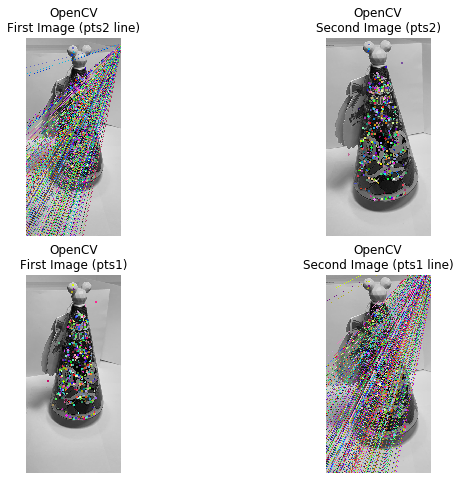

In [5]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

def draw_epilines_cv(gray1, gray2, inlier1, inlier2, F, name='epipolar_line_cv.png'):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1_cv = cv2.computeCorrespondEpilines(inlier2.reshape(-1,1,2), 2, F)
    lines1_cv = lines1_cv.reshape(-1,3)
    img5, img6 = drawlines(gray1, gray2, lines1_cv, inlier1.astype(np.int32), inlier2.astype(np.int32))
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2_cv = cv2.computeCorrespondEpilines(inlier1.reshape(-1,1,2), 1, F)
    lines2_cv = lines2_cv.reshape(-1,3)
    img3, img4 = drawlines(gray2, gray1, lines2_cv, inlier2.astype(np.int32), inlier1.astype(np.int32))

    plt.subplot(221), plt.axis('off'), plt.title('OpenCV\nFirst Image (pts2 line)'), plt.imshow(img5)
    plt.subplot(222), plt.axis('off'), plt.title('OpenCV\nSecond Image (pts2)'), plt.imshow(img6)
    plt.subplot(223), plt.axis('off'), plt.title('OpenCV\nFirst Image (pts1)'), plt.imshow(img4)
    plt.subplot(224), plt.axis('off'), plt.title('OpenCV\nSecond Image (pts1 line)'), plt.imshow(img3)

inlier1 = ransac_data[:, 0:2]
inlier2 = ransac_data[:, 3:5] 
draw_epilines_cv(gray1, gray2, inlier1, inlier2, F)

## computeCorrespondEpilines
From the fundamental matrix definition (see findFundamentalMat() ), line $l^{(2)}_i$ in the second image for the point $p^{(1)}_i$ in the first image (when whichImage=1 ) is computed as:

$l_{i}^{(2)}=F p_{i}^{(1)}$

And vice versa, when whichImage=2, $l^{(1)}_i$ is computed from $p^{(2)}_i$ as:

$l_{i}^{(1)}=F^{\top} p_{i}^{(2)}$

Line coefficients are defined up to a scale. They are normalized so that $a_i^2+b_i^2=1$ .




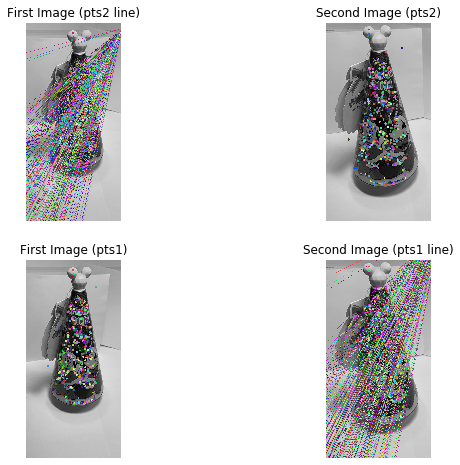

In [6]:
def norm_line(lines):
    a = lines[:,0:1]
    b = lines[:,1:2]
    length = np.sqrt(a**2 + b**2)
    return lines / length

def draw_epilines(gray1, gray2, inlier1, inlier2, F):
    
    # image2 @ F @ image1
    # Second image line l2 and first image points p1
    lines2 = (F @ add_z_axis(inlier1).T).T # (3,3)@(3,pts1) .T = (pts1,3)
    lines2_norm = norm_line(lines2)
    img3, img4 = drawlines(gray2, gray1, lines2_norm, inlier2.astype('int32'), inlier1.astype('int32'))
    
    # First image line l1 and second image points p2
    lines1 = (F.T @ add_z_axis(inlier2).T).T  #(pts2,3)@(3,3) .T = (pts2,3)
    lines1_norm = norm_line(lines1)
    img5, img6 = drawlines(gray1, gray2, lines1_norm, inlier1.astype('int32'), inlier2.astype('int32'))


    

    plt.subplot(221), plt.axis('off'), plt.title('First Image (pts2 line)'), plt.imshow(img5)
    plt.subplot(222), plt.axis('off'), plt.title('Second Image (pts2)'), plt.imshow(img6)
    plt.subplot(223), plt.axis('off'), plt.title('First Image (pts1)'), plt.imshow(img4)
    plt.subplot(224), plt.axis('off'), plt.title('Second Image (pts1 line)'), plt.imshow(img3)
    # plt.savefig(name)
    
inlier1 = ransac_data[:, 0:2]
inlier2 = ransac_data[:, 3:5] 
draw_epilines(gray1, gray2, inlier1, inlier2, F)

## Get Essential (E) matrix from Fundamental matrix (F)
fundamental matrix: $x_{1}^{\top} F x_{2}=0$

$x=K \hat{x} \Rightarrow \hat{x}_{1}^{\top} K_{1}^{\top} F K_{2}^{\top} \hat{x}_{2}^{\top}=0$

essential matrix: $E=K_{1}^{\top} F K_{2}$


### 4 projections
$[\mathrm{U}, \mathrm{S}, \mathrm{V}]=\mathrm{svd}(\mathrm{E})$

$\mathrm{m}=(\mathrm{S}(1,1)+\mathrm{S}(2,2)) / 2$

$\mathrm{E}=\mathrm{U}^{*}[\mathrm{m}, 0,0 ; 0, \mathrm{m}, 0 ; 0,0,0]^{*} \mathrm{V}^{\prime}$

$[\mathrm{U}, \mathrm{S}, \mathrm{V}]=\operatorname{svd}(\mathrm{E}) ;$

$\mathrm{W}=[0,-1,0 ; 1,0,0 ; 0,0,1]$

$\begin{array}{l}
\mathbf{P}_{2}=\left[\mathbf{U} \mathbf{W} \mathbf{V}^{\top} |+\mathbf{u}_{3}\right] \\
\mathbf{P}_{2}=\left[\mathbf{U} \mathbf{W} \mathbf{V}^{\top} |-\mathbf{u}_{3}\right] \\
\mathbf{P}_{2}=\left[\mathbf{U} \mathbf{W}^{\top} \mathbf{V}^{\top} |+\mathbf{u}_{3}\right] \\
\mathbf{P}_{2}=\left[\mathbf{U} \mathbf{W}^{\top} \mathbf{V}^{\top} |-\mathbf{u}_{3}\right]
\end{array}$

In [7]:
##### 5 Decompose E into [R|t]
# implement decomposeEssentialMat
# Use SVD, E = U @ diag(1,1,0) @ V.T
# There are 4 possible choices of the second extrinsic matrix.
# From Stereo and Optical Flow P.127

# The extrinsic matrix of the first camera
# Assume P = [R|t] = [I|0]


def get_extrinsics(E):
    U, S, Vh = np.linalg.svd(E)
    m = (S[0] + S[1]) / 2
    Enew = U @ np.array([[m, 0, 0], [0, m, 0], [0, 0, 0]]) @ Vh
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    if np.linalg.det(U@Vh):
        Vh = -Vh
    R1 =  U @ W.T @ Vh
    R2 =  U @ W @ Vh
    t = U[:,2:] # (3,1)
    return R1, R2, t

def get4projections(R1, R2, t):
    P1 = np.hstack((R1,t))
    P2 = np.hstack((R1,-t))
    P3 = np.hstack((R2,t))
    P4 = np.hstack((R2,-t))
    return P1, P2, P3, P4

E = K1.T @ F @ K2
P = np.eye(4)[0:3, :]
R1, R2, t = get_extrinsics(E)
P1, P2, P3, P4 = get4projections(R1, R2, t)

## Triangulation
$\begin{array}{l}
x=w\left[\begin{array}{l}
u \\
v \\
1
\end{array}\right] \quad \mathbf{P}=\left[\begin{array}{l}
\mathbf{p}_{1}^{\top} \\
\mathbf{p}_{2}^{\top} \\
\mathbf{p}_{3}^{\top}
\end{array}\right] \quad A=\left[\begin{array}{l}
u \mathbf{p}_{3}^{\top}-\mathbf{p}_{1}^{\top} \\
v \mathbf{p}_{3}^{\top}-\mathbf{p}_{2}^{\top} \\
u^{\prime} \mathbf{p}_{3}^{\prime \top}-\mathbf{p}_{1}^{\prime \top} \\
v^{\prime} \mathbf{p}_{3}^{\prime \top}-\mathbf{p}_{2}^{\prime \top}
\end{array}\right] \\
x^{\prime}=w\left[\begin{array}{l}
u \\
v^{\prime} \\
1
\end{array}\right]
\end{array}$

$Given \ P,P′,x,x′\\
1.precondition \ points \ and \ projection \ matrices\\
2.create \ matrix \ A\\
3.[U,S,V]=svd(A)\\
4.X=V(:,end)$

In [8]:
##### 6 Triangulation
    # implement triangulatePoints (P.129)
    # P is the extrinsic matrix of the first camera
    # P1, P2, P3, P4 are the 4 candidates of the second camera extrinsic matrix
    # Only use inliers to reconstruct 3D world

def get_3d_pts(K1, K2, P, P_, pts1, pts2):
    # cv2.triangulatePoints
    # first & second arguments are project matrix K[R|t] corresponding to 1st & 2nd images
    # third & fourth arguments are 2 by n array of feature points corresponding to 1st & 2nd images.
    # Return 3D homogeneous points (4 by N array)
    pm1 = K1 @ P # (3,3)@(3,4) = (3,4)
    pm2 = K2 @ P_
    point3d = np.zeros([4, pts1.shape[0]]) # (4,n)
    A = np.zeros([4, 4])
    
    for i in range(pts1.shape[0]):
        A[0,:] = pts1[i, 0]*pm1[2,:]-pm1[0,:]
        A[1,:] = pts1[i, 1]*pm1[2,:]-pm1[1,:]
        A[2,:] = pts2[i, 0]*pm2[2,:]-pm2[0,:]
        A[3,:] = pts2[i, 1]*pm2[2,:]-pm2[1,:]
    
        u, s, vh = np.linalg.svd(A) # vh(4,4)
        point3d[:,i] = vh[3,:]/vh[3,3]

    return point3d


point_1 = get_3d_pts(K1, K2, P, P1, inlier1, inlier2)
point_2 = get_3d_pts(K1, K2, P, P2, inlier1, inlier2)
point_3 = get_3d_pts(K1, K2, P, P3, inlier1, inlier2)
point_4 = get_3d_pts(K1, K2, P, P4, inlier1, inlier2)

## Find out the most appropriate solution of essential matrix

* Camera Extrinsic [R|t]

$\left[\begin{array}{c}
X_{c a m} \\
Y_{c a m} \\
Z_{c a m}
\end{array}\right]=R\left[\begin{array}{c}
X_{\text {world}} \\
Y_{\text {world}} \\
Z_{\text {world}}
\end{array}\right]+t \Leftrightarrow\left[\begin{array}{c}
X_{\text {world}} \\
Y_{\text {world}} \\
Z_{\text {world}}
\end{array}\right]=R^{-1}\left(\left[\begin{array}{c}
X_{\text {cam}} \\
Y_{\text {cam}} \\
Z_{\text {cam}}
\end{array}\right]-t\right)=R^{\top}\left[\begin{array}{c}
X_{\text {cam}} \\
Y_{\text {cam}} \\
Z_{\text {cam}}
\end{array}\right]-R^{\top} t$

* Camera Center

$\left[\begin{array}{l}
X_{\text {cam}} \\
Y_{\text {cam}} \\
Z_{\text {cam}}
\end{array}\right]=\left[\begin{array}{l}
0 \\
0 \\
0
\end{array}\right] \Leftrightarrow \mathbf{C}=\left[\begin{array}{c}
X_{\text {world}} \\
Y_{\text {world}} \\
Z_{\text {world}}
\end{array}\right]=R^{\top}\left[\begin{array}{l}
0 \\
0 \\
0
\end{array}\right]-R^{\top} t=-R^{\top} t$

* View Direction

$\left[\begin{array}{l}
0 \\
0 \\
1
\end{array}\right]-\left[\begin{array}{l}
0 \\
0 \\
0
\end{array}\right] \Leftrightarrow\left(R^{\top}\left[\begin{array}{l}
0 \\
0 \\
1
\end{array}\right]-R^{\top} t\right)-(\mathbf{C})=\left(R(3,:)^{\top}-R^{\top} t\right)-\left(-R^{\top} t\right)=R(3,:)^{\top}$

$ * \text { Just need to test }(X-\mathbf{C}) \cdot R(3,:)^{\top}>0 ?$

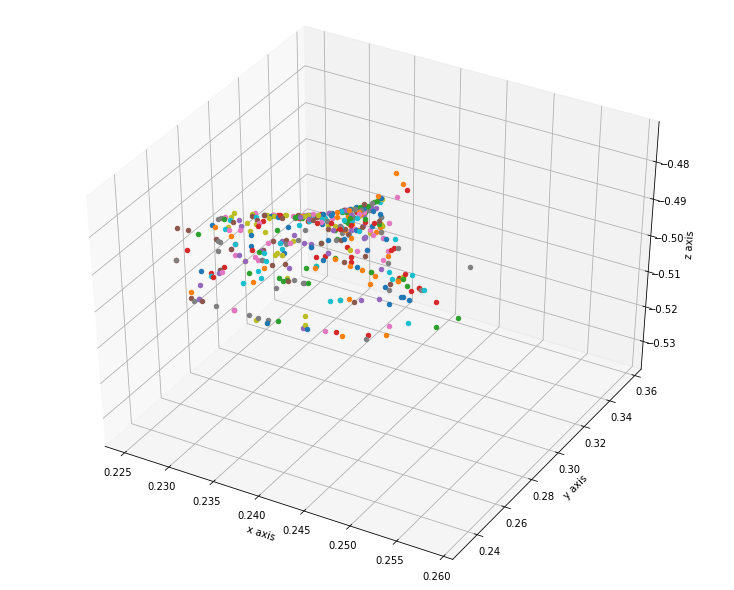

In [9]:
##### 7 In front of the camera?
# P130 - P.131
# test criteria np.dot(point3d, R1[2:,:]) > 0

from mpl_toolkits.mplot3d import Axes3D

def max_front_pts(pt3d1, pt3d2, pt3d3, pt3d4, R1, R2, t):
    C1 = - R1.T @ t # (3,3)@(3,1) = (3,1)
    C2 = R1.T @ t
    C3 = - R2.T @ t
    C4 = R2.T @ t
    #pt3d (4,n)

    front_1 = R1[2,:] @ (pt3d1[0:3,:]-C1) #(1,3)@ (3,n)-(3,1) = (1,n)
    front_sum1 = np.count_nonzero(front_1 > 0)
    front_2 = R1[2,:] @ (pt3d2[0:3,:]-C2)
    front_sum2 = np.count_nonzero(front_2 > 0)
    front_3 = R2[2,:] @ (pt3d3[0:3,:]-C3)
    front_sum3 = np.count_nonzero(front_3 > 0)
    front_4 = R2[2,:] @ (pt3d4[0:3,:]-C4)
    front_sum4 = np.count_nonzero(front_4 > 0)
    
    idx = np.argmax([front_sum1, front_sum2, front_sum3, front_sum4])
    
    if idx == 0:
        return pt3d1
    elif idx == 1:
        return pt3d2
    elif idx == 2:
        return pt3d3
    elif idx == 3:
        return pt3d4
    else:
        raise ValueError("did not meet fit acceptance criteria")


def plot(final3d):
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(final3d.shape[1]):
        ax.scatter(final3d[0, i], final3d[1, i], final3d[2, i])
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    ax.view_init(elev=40)
    plt.show()
    
final3d = max_front_pts(point_1, point_2, point_3, point_4, R1, R2, t)
plot(final3d)

In [10]:
np.savetxt("_3dpts.csv", final3d.T[:,0:3], delimiter=",")
np.savetxt("_inlier1.csv", inlier1, delimiter=",")
np.savetxt("_inlier2.csv", inlier2, delimiter=",")